In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import cv2

In [3]:
IMG_SIZE = 227  
BATCH_SIZE = 16  

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

# Change the directory to your dataset path if needed
dataset = keras.utils.image_dataset_from_directory(
    directory=r"C:\Users\91994\Downloads\poultry_diseases",  # Update to your dataset path if necessary
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
class_names = dataset.class_names


Found 6812 files belonging to 4 classes.


In [5]:
train_ds = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Function to normalize images
def process(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)
test_ds = test_ds.map(process)


In [7]:
def AlexNet(input_shape=(227, 227, 3), num_classes=4):
    model = Sequential([
        layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        
        layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        
        layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Learning rate scheduler
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True
)

# Build and compile the AlexNet model
alexnet = AlexNet(input_shape=(227, 227, 3), num_classes=4)
alexnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

C:\Users\91994\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Assuming train_ds and val_ds are predefined datasets
history = alexnet.fit(
    train_ds,
    epochs=5,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/5
340/340 ━━━━━━━━━━━━━━━━━━━━ 633s 2s/step - accuracy: 0.5473 - loss: 1.0248 - val_accuracy: 0.8174 - val_loss: 0.5207
Epoch 2/5
340/340 ━━━━━━━━━━━━━━━━━━━━ 607s 2s/step - accuracy: 0.8359 - loss: 0.4802 - val_accuracy: 0.8765 - val_loss: 0.3850
Epoch 3/5
340/340 ━━━━━━━━━━━━━━━━━━━━ 754s 2s/step - accuracy: 0.8810 - loss: 0.3504 - val_accuracy: 0.8884 - val_loss: 0.3080
Epoch 4/5
340/340 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step - accuracy: 0.8944 - loss: 0.2985 - val_accuracy: 0.9117 - val_loss: 0.2329
Epoch 5/5
340/340 ━━━━━━━━━━━━━━━━━━━━ 743s 2s/step - accuracy: 0.9006 - loss: 0.2825 - val_accuracy: 0.9132 - val_loss: 0.2428


In [11]:
alexnet.save_weights('alexnet.weights.h5')

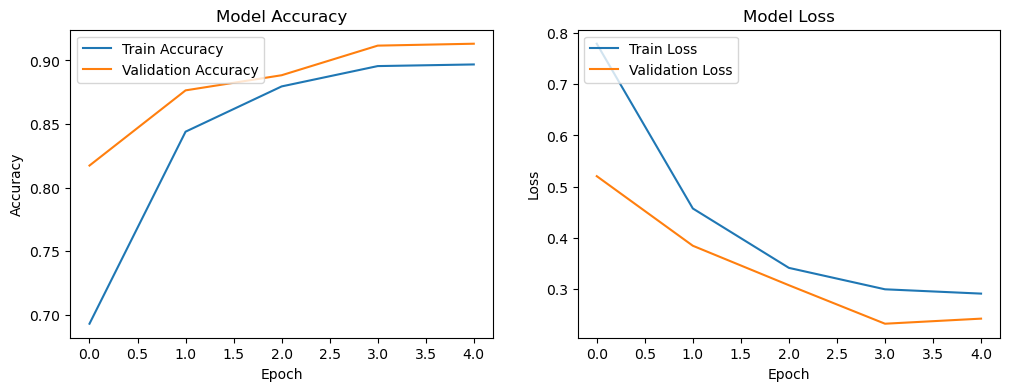

In [13]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


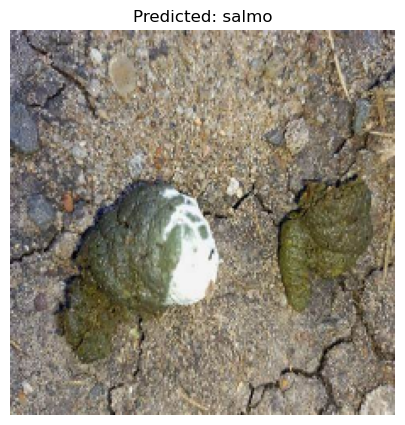

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


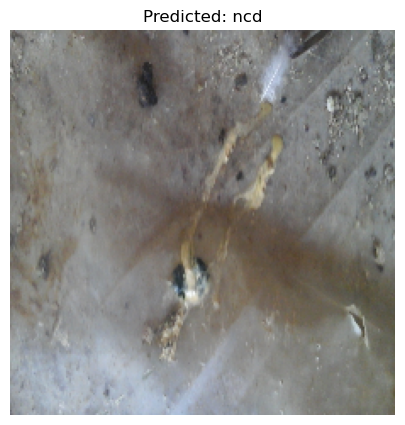

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


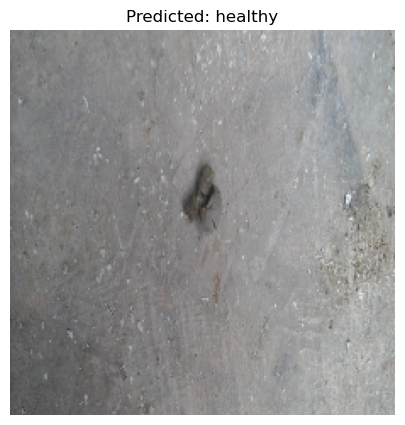

In [15]:
import cv2

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = tf.image.resize(image, (227, 227))  # AlexNet uses 227x227 input size
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image / 255.0, tf.float32)
    return image

def predict(model, image):
    prediction = model.predict(image)
    predicted_class = tf.argmax(prediction, axis=1).numpy()[0]
    return class_names[predicted_class]

# Example image prediction and display
image_path = r"C:\Users\91994\Downloads\OIP.jpeg"
plt.figure(figsize=(15, 5))
image = load_and_preprocess_image(image_path)
predicted_class = predict(alexnet, image)
image_display = cv2.imread(image_path)
image_display = cv2.cvtColor(image_display, cv2.COLOR_BGR2RGB)
image_display = cv2.resize(image_display, (227, 227))
plt.imshow(image_display)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

# Another example
image_path1 = r"C:\Users\91994\Downloads\poultry_diseases\ncd\ncd.8.jpg"
plt.figure(figsize=(15, 5))
image1 = load_and_preprocess_image(image_path1)
predicted_class1 = predict(alexnet, image1)
image_display1 = cv2.imread(image_path1)
image_display1 = cv2.cvtColor(image_display1, cv2.COLOR_BGR2RGB)
image_display1 = cv2.resize(image_display1, (227, 227))
plt.imshow(image_display1)
plt.title(f"Predicted: {predicted_class1}")
plt.axis('off')
plt.show()

# Third example
image_path2 = r"C:\Users\91994\Downloads\poultry_diseases\healthy\healthy.905.jpg"
plt.figure(figsize=(15, 5))
image2 = load_and_preprocess_image(image_path2)
predicted_class2 = predict(alexnet, image2)
image_display2 = cv2.imread(image_path2)
image_display2 = cv2.cvtColor(image_display2, cv2.COLOR_BGR2RGB)
image_display2 = cv2.resize(image_display2, (227, 227))
plt.imshow(image_display2)
plt.title(f"Predicted: {predicted_class2}")
plt.axis('off')
plt.show()

In [25]:
!pip install scikit-learn


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

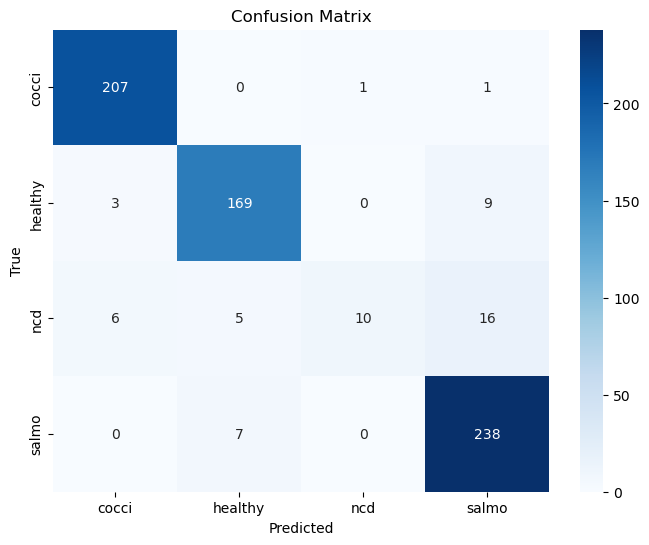

Classification Report:
              precision    recall  f1-score   support

       cocci       0.96      0.99      0.97       209
     healthy       0.93      0.93      0.93       181
         ncd       0.91      0.27      0.42        37
       salmo       0.90      0.97      0.94       245

    accuracy                           0.93       672
   macro avg       0.93      0.79      0.81       672
weighted avg       0.93      0.93      0.92       672



In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Assuming 'val_ds' or 'test_ds' is your validation or test dataset
# Collecting the true labels and predictions
true_labels = []
predicted_labels = []

for images, labels in val_ds:
    predictions = alexnet.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_classes)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report for more details
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))
